In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def clamp(img):
    arr_min = sorted(list(set(img.flatten())))[1]
    arr_max = np.max(img)
    filtered_img = np.clip(img, a_min = arr_min, a_max = arr_max)
    filtered_img = cv.normalize(filtered_img, filtered_img, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    filtered_img = np.uint8(filtered_img)
    return filtered_img

In [17]:
# imgL = cv.imread('data/not_board/imageL3.png')
# imgR = cv.imread('data/not_board/imageR3.png')
imgL = cv.imread('data/initial/img1-5.jpg')
imgR = cv.imread('data/initial/img2-5.jpg')
# imgL = cv.imread('bottle_l.jpg')
# imgR = cv.imread('bottle_r.jpg')

sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

imgSift = cv.drawKeypoints(
    imgL, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   #matchesMask=matchesMask,
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    imgL, kp1, imgR, kp2, matches[300:500], None, **draw_params)
    #imgL, kp1, imgR, kp2, matches, None, **draw_params)


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

h1, w1, something = imgL.shape
h2, w2, something = imgR.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

img1_rectified = cv.warpPerspective(imgL, H1, (w1, h1))
img2_rectified = cv.warpPerspective(imgR, H2, (w2, h2))

block_size = 11
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity = stereo.compute(img1_rectified, img2_rectified)

wsize=31
max_disp = 128
sigma = 1.5
lmbda = 8000.0
left_matcher = stereo

right_matcher = cv.ximgproc.createRightMatcher(left_matcher)
lmbda = 8000
sigma = 1.5
wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)
displ = left_matcher.compute(img1_rectified, img2_rectified)
dispr = right_matcher.compute(img2_rectified, img1_rectified)
displ = np.int16(displ)
dispr = np.int16(dispr)
#filtered_disparity = wls_filter.filter(disparity_map_left = displ,left_view = img1_rectified, disparity_map_right = dispr, right_view = img2_rectified) / 16.0
filtered_disparity = wls_filter.filter(disparity_map_left = displ,left_view = img1_rectified, disparity_map_right = dispr) / 16.0
fil_disp_right = wls_filter.filter(disparity_map_left = displ,left_view = img2_rectified, disparity_map_right = dispr) / 16.0

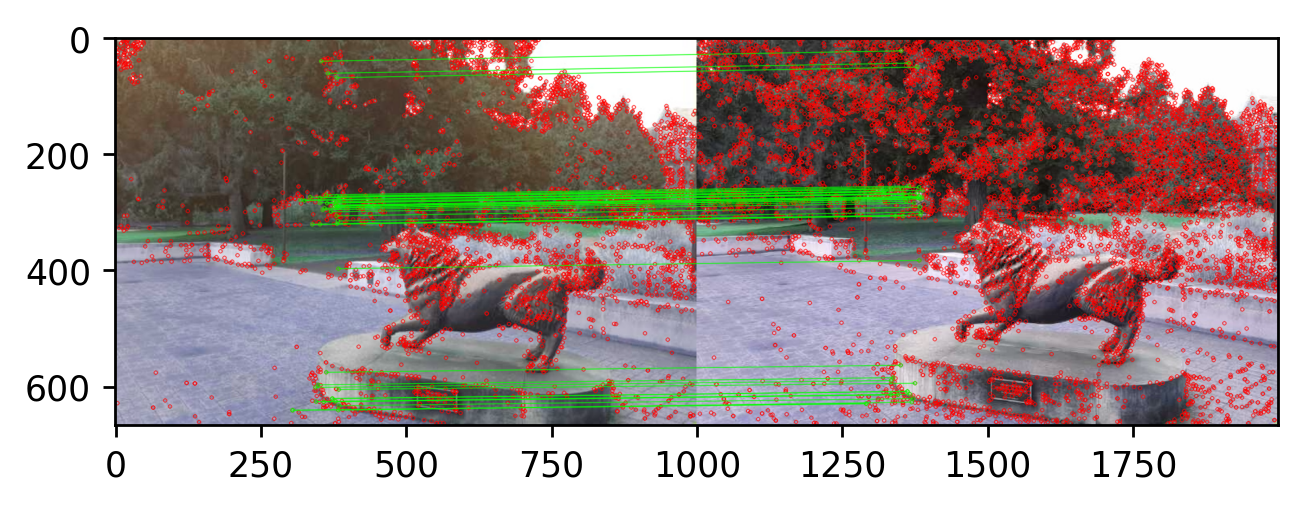

In [18]:
plt.figure(1234123, dpi = 250)
plt.imshow(keypoint_matches)

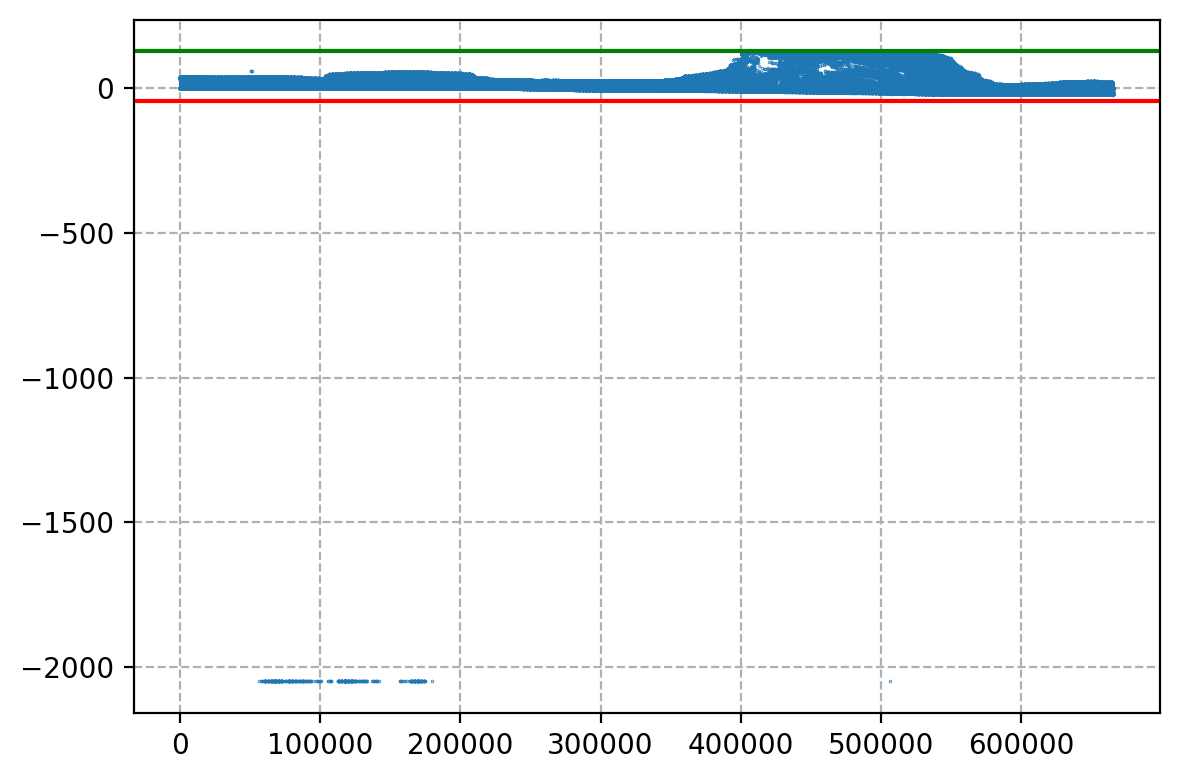

In [11]:
plt.figure(1, dpi = 200)
plt.plot(filtered_disparity.flatten(), '.', markersize=0.5)
plt.axhline(np.mean(filtered_disparity) - np.std(filtered_disparity), color = 'r')
plt.axhline(np.max(filtered_disparity), color = 'g')
plt.grid(linestyle = '--')

plt.tight_layout()

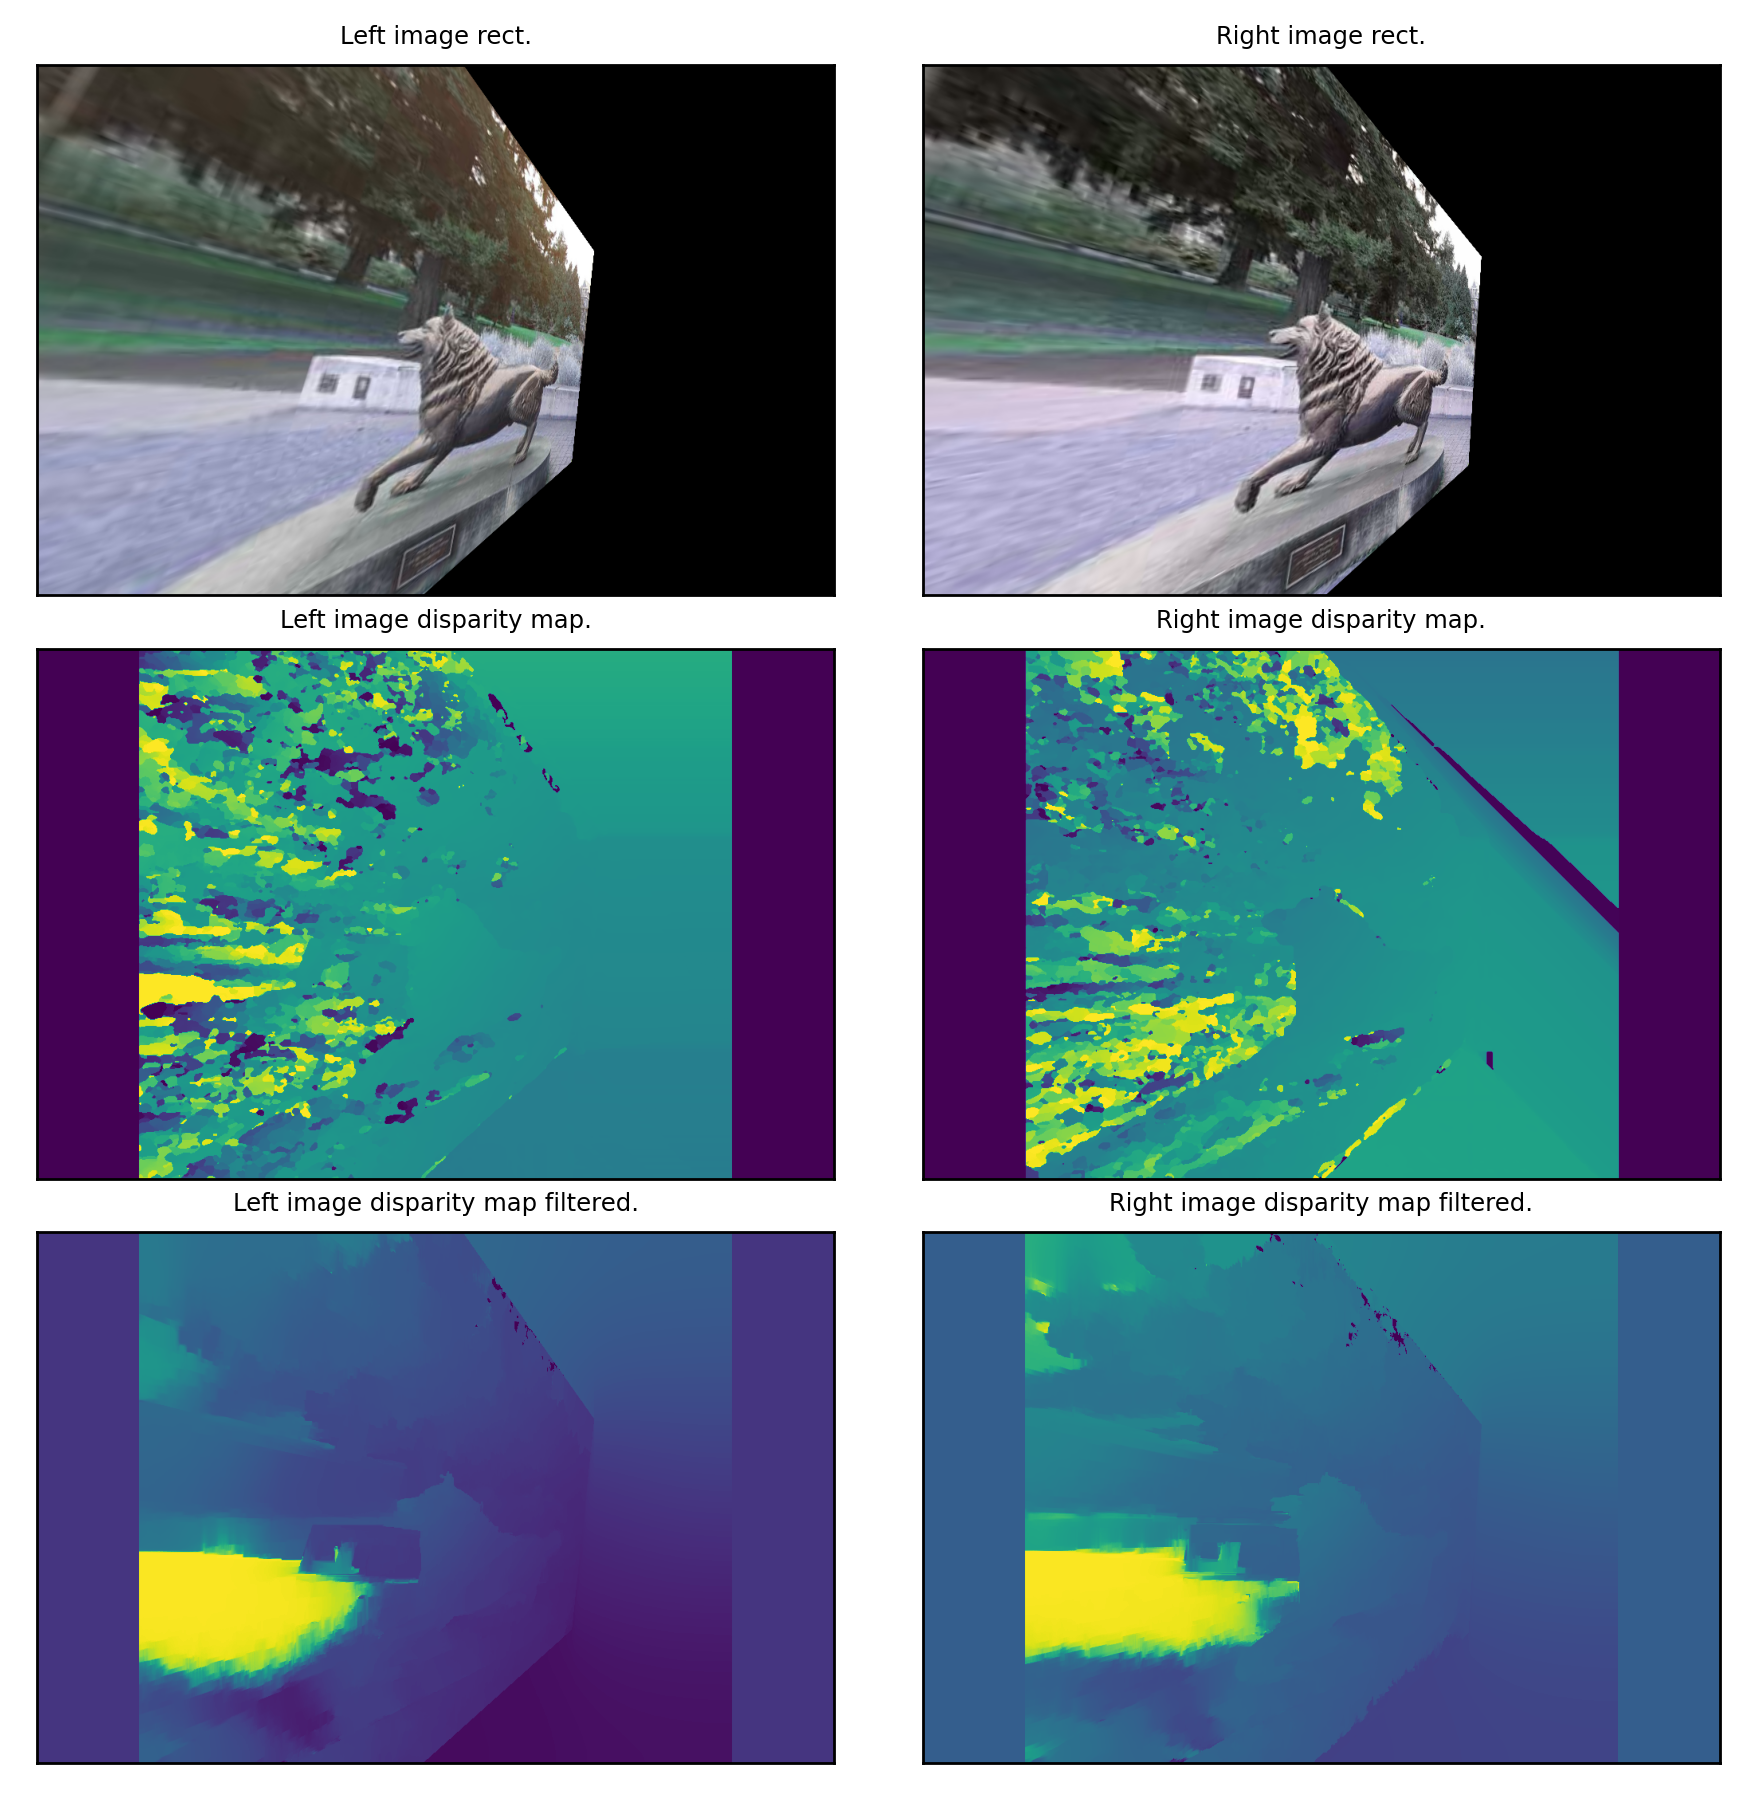

In [16]:
fig = plt.figure(4, figsize = (7,7), dpi = 250)
fig.patch.set_facecolor('w')

nrows = 3
ncols = 2

plt.subplot(nrows,ncols,1)
plt.title("Left image rect.", fontsize=7)
plt.imshow(img1_rectified)

plt.subplot(nrows,ncols,3)
plt.title("Left image disparity map.", fontsize=7)
plt.imshow(displ)

plt.subplot(nrows,ncols,5)
plt.title("Left image disparity map filtered.", fontsize=7)
plt.imshow(clamp(filtered_disparity))

plt.subplot(nrows,ncols,2)
plt.title("Right image rect.", fontsize=7)
plt.imshow(img2_rectified)

plt.subplot(nrows,ncols,4)
plt.title("Right image disparity map.", fontsize=7)
plt.imshow(dispr)

plt.subplot(nrows,ncols,6)
plt.title("Right image disparity map filtered.", fontsize=7)
plt.imshow(clamp(fil_disp_right))

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout(pad = 0)
plt.subplots_adjust(wspace=0.025, hspace = 0.1)